# WF-samples start here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick

mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    print("Number of total (including modified) peptides in "+file+" "+str(len(data.index)))
    for_stdev.append(len(data.index))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4]) #this can be changed to view different amounts of AA
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)

print("Standard deviation: "+ str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
df.head()

Number of total (including modified) peptides in peptide _WF1.xlsx 3687
Number of un-modified peptides in peptide _WF1.xlsx 3140
Number of total (including modified) peptides in peptide_WF2.xlsx 4220
Number of un-modified peptides in peptide_WF2.xlsx 3637
Number of total (including modified) peptides in peptide_WF3.xlsx 2960
Number of un-modified peptides in peptide_WF3.xlsx 2564
Number of total (including modified) peptides in peptide_WF4.xlsx 2423
Number of un-modified peptides in peptide_WF4.xlsx 2094
Number of total (including modified) peptides in peptide_WF5.xlsx 3367
Number of un-modified peptides in peptide_WF5.xlsx 2920
Standard deviation: 613.2629452363807
Total amount of peptides 14355
Average length: 12.688956433637285
Average mass: 1407.546652841664
Total number of peptides with feature>=4: 1974
Number of peptides with feature>=4: 1974, in percent: 13.751306165099269 %


,Peptide,Mass,Length,RT,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.595800,8.0,14.917000,161,23.0,8.0,38.0,53.0,38.0,5,PSLQ,APVR,P,R
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1859.410673,18.0,73.682667,67,12.0,13.0,16.0,18.0,8.0,5,AVGK,GMAF,A,F
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.240900,9.0,65.527167,66,10.0,15.0,13.0,15.0,13.0,5,NHQL,GLTF,N,F
sp|P06727|APOA4_HUMAN,SLAELGGHLDQQVEEF,1771.564000,16.0,99.716833,66,16.0,13.0,11.0,14.0,12.0,5,SLAE,VEEF,S,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,801.941700,7.0,39.656000,61,13.0,13.0,14.0,9.0,12.0,5,NFRP,PGVL,N,L


In [2]:
def group(list):
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])
aminoacids

{'A': 3156,
 'G': 4614,
 'V': 3622,
 'L': 5648,
 'I': 1740,
 'P': 3674,
 'F': 3450,
 'W': 256,
 'M': 965,
 'S': 3702,
 'T': 3008,
 'C': 0,
 'Y': 1143,
 'N': 1530,
 'Q': 1889,
 'K': 2060,
 'R': 1054,
 'H': 1283,
 'D': 3046,
 'E': 4533}

## Graph of aminoacid frequency in complete sequences

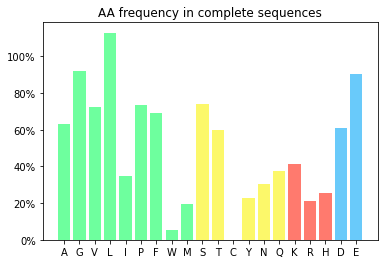

Text(0.5, 1.0, 'AA frequency in complete sequences')

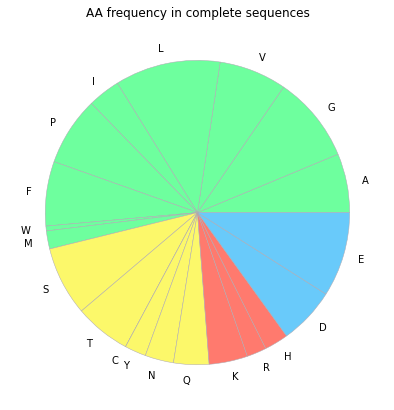

In [3]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in complete sequences')
plt.show()
fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in complete sequences')

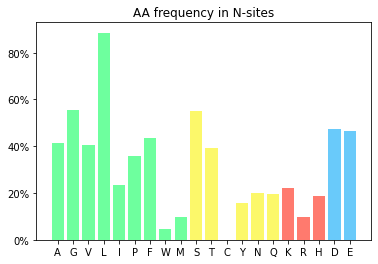

Text(0.5, 1.0, 'AA frequency in N-sites')

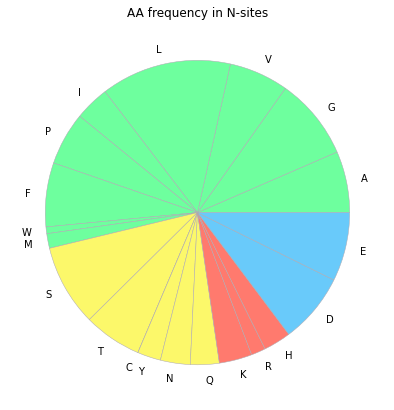

In [4]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(N_aminoacids.values(),labels = N_aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in N-sites')

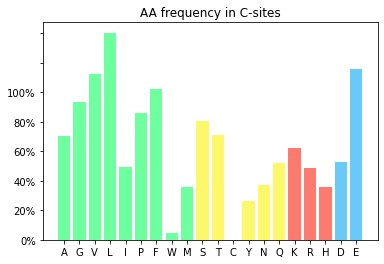

Text(0.5, 1.0, 'AA frequency in C-sites')

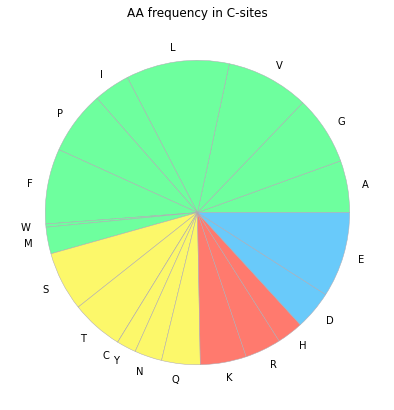

In [5]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp)
plt.title('AA frequency in C-sites')

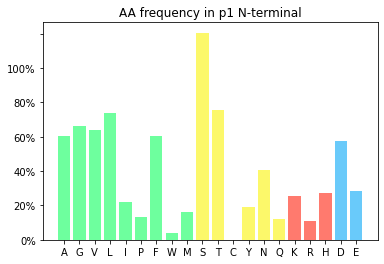

Text(0.5, 1.0, 'AA frequency in p1 N-terminal')

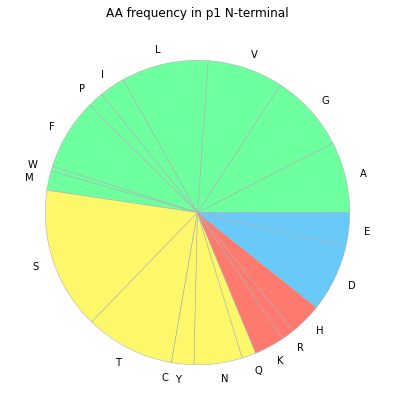

In [6]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
plt.xticks(range(len(First_aa)), list(First_aa.keys()))
plt.title('AA frequency in p1 N-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 N-terminal')

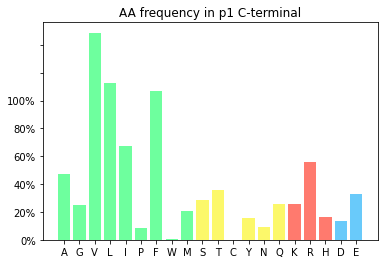

Text(0.5, 1.0, 'AA frequency in p1 C-terminal')

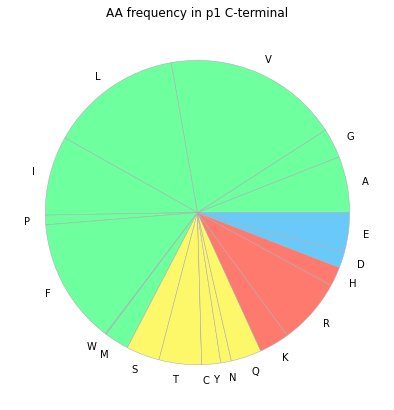

In [7]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
plt.xticks(range(len(Last_aa)), list(Last_aa.keys()))
plt.title('AA frequency in p1 C-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 C-terminal')

### How does feature and count correlate in these samples? Are there certain peptides with abnormal feature?

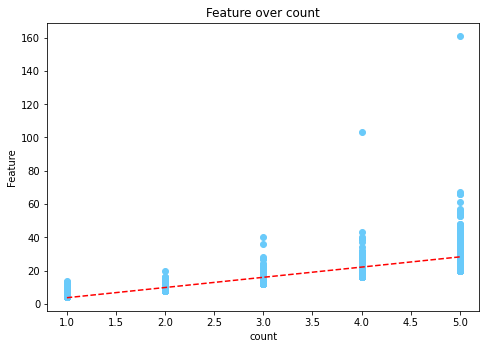

[ 6.12735666 -2.34968614]
0.6818843822688946


In [8]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='#69cafa')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()

correlation_matrix = np.corrcoef(df['count'], df['#Feature'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [9]:
df.sort_values(['#Feature'], ascending=False).head()

,Peptide,Mass,Length,RT,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.595800,8.0,14.917000,161,23.0,8.0,38.0,53.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.844700,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1859.410673,18.0,73.682667,67,12.0,13.0,16.0,18.0,8.0,5,AVGK,GMAF,A,F
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.240900,9.0,65.527167,66,10.0,15.0,13.0,15.0,13.0,5,NHQL,GLTF,N,F
sp|P06727|APOA4_HUMAN,SLAELGGHLDQQVEEF,1771.564000,16.0,99.716833,66,16.0,13.0,11.0,14.0,12.0,5,SLAE,VEEF,S,F


### What are the most frequent N,C-terminals and what is their sequence? How often are they found? Are there outliers? OOPS: Mass length etc are fucked

In [10]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['#Feature'], ascending=False)

df_N.head()


#Feature  #Feature WF1  #Feature WF2  \
Accession            N-cut                                         
sp|P69905|HBA_HUMAN  TYFP        235          56.0          55.0   
sp|P02671|FIBA_HUMAN DTAS        151          19.0          30.0   
                     STGK        136          22.0          36.0   
                     FDTA        137          20.0          38.0   
sp|P69905|HBA_HUMAN  SLDK        153          44.0          43.0   

                            #Feature WF 3  #Feature WF4  #Feature WF5  count  
Accession            N-cut                                                    
sp|P69905|HBA_HUMAN  TYFP            59.0          10.0          55.0     39  
sp|P02671|FIBA_HUMAN DTAS            42.0          36.0          24.0     31  
                     STGK            39.0          30.0           9.0     31  
                     FDTA            33.0          21.0          25.0     30  
sp|P69905|HBA_HUMAN  SLDK            26.0           0.0          40.0     30

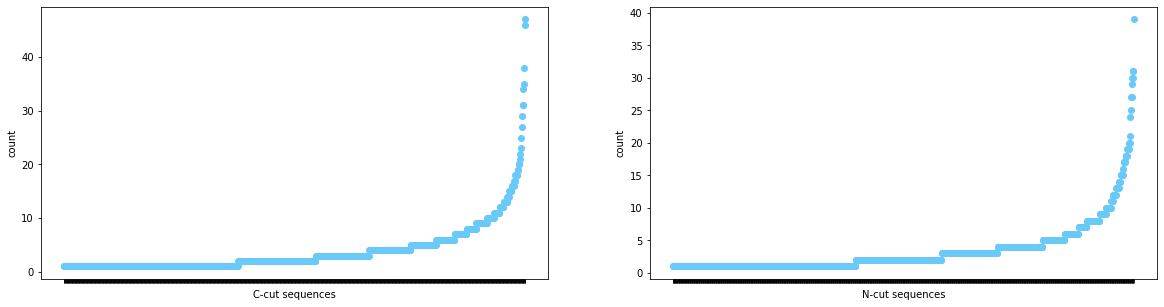

In [11]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('count')
df_C=df_C.sort_values('count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0

### What are the most frequent groups of AA at the N,C-terminal? Are there any favou#ff7a6e combinations?

In [12]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','#Feature'], ascending=False)
df_C.head()

,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count
C-grouped,,,,,,,
NNNN,1307,262.0,247.0,287.0,176.0,333.0,247
NPNN,1012,224.0,312.0,184.0,132.0,160.0,216
NANN,709,142.0,167.0,160.0,121.0,119.0,156
PNNN,593,102.0,150.0,99.0,85.0,157.0,138
NNPN,652,131.0,159.0,162.0,90.0,110.0,132


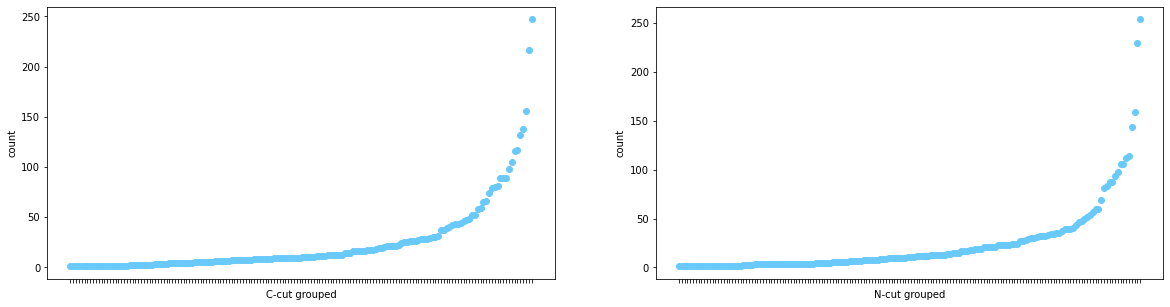

In [13]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['count'], ascending=True)
df_C=df_C.sort_values(['count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0

# Infected samples start here

In [14]:
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!

mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    for_stdev.append(len(data.index))
    print("Number of modified peptides in "+file+" "+str(len(data.index)))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature Sample 31','#Feature Sample 34', '#Feature Sample 39','count', 'N-cut', 'C-cut', 'First aa', 'Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)
print("Standard deviation: "+str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])
print(aminoacids)
df.head()

Number of modified peptides in peptide_sample_31.xlsx 5103
Number of un-modified peptides in peptide_sample_31.xlsx 4055
Number of modified peptides in peptide_sample_34.xlsx 1412
Number of un-modified peptides in peptide_sample_34.xlsx 1218
Number of modified peptides in peptide_sample_39.xlsx 4929
Number of un-modified peptides in peptide_sample_39.xlsx 3817
Standard deviation: 1700.4262864221887
Total amount of peptides 9090
Average length: 13.731363331094695
Average mass: 1494.5794611588155
Total number of peptides with feature>=4: 1489
Number of peptides with feature>=4: 1489, in percent: 16.38063806380638 %
{'A': 3679, 'G': 2527, 'V': 2677, 'L': 2982, 'I': 320, 'P': 1577, 'F': 1232, 'W': 307, 'M': 413, 'S': 1751, 'T': 1605, 'C': 0, 'Y': 633, 'N': 1085, 'Q': 570, 'K': 2102, 'R': 799, 'H': 1578, 'D': 1813, 'E': 1852}


,Peptide,Mass,Length,RT,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.1440,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.8530,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R


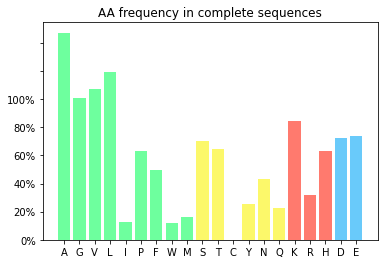

Text(0.5, 1.0, 'AA frequency in complete sequences')

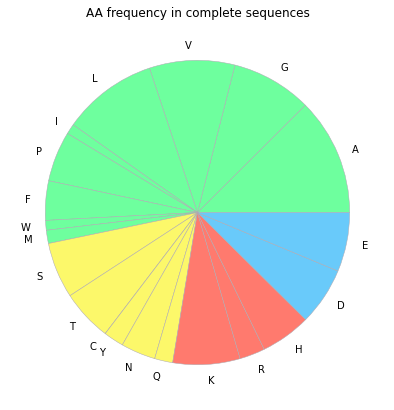

In [15]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in complete sequences')
plt.show()
fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in complete sequences')

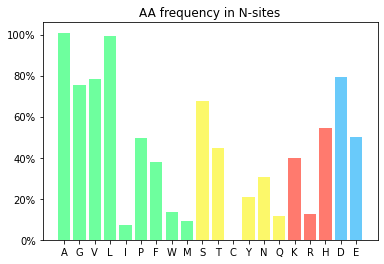

Text(0.5, 1.0, 'AA frequency in N-sites')

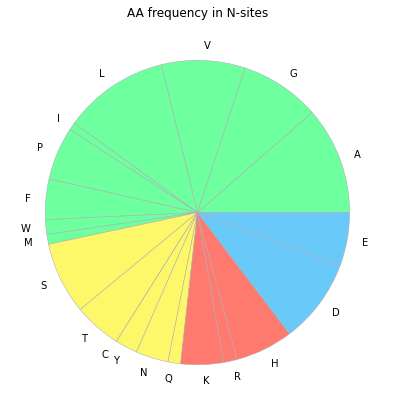

In [16]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(N_aminoacids.values(),labels = N_aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in N-sites')

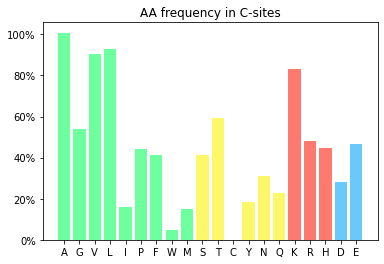

Text(0.5, 1.0, 'AA frequency in C-sites')

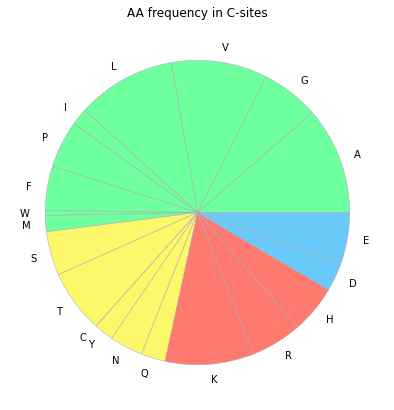

In [17]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp)
plt.title('AA frequency in C-sites')

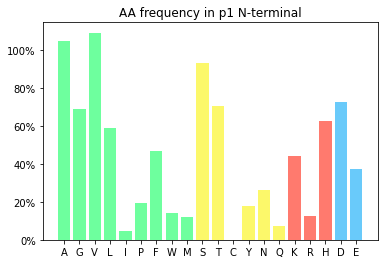

Text(0.5, 1.0, 'AA frequency in p1 N-terminal')

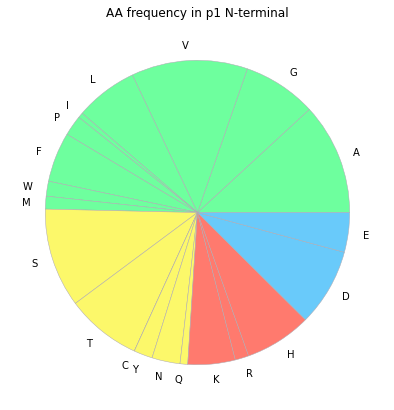

In [18]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
plt.xticks(range(len(First_aa)), list(First_aa.keys()))
plt.title('AA frequency in p1 N-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 N-terminal')

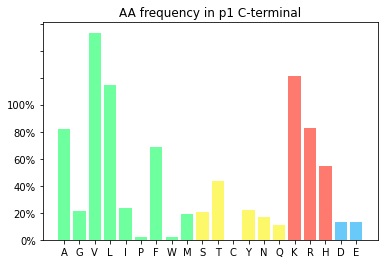

Text(0.5, 1.0, 'AA frequency in p1 C-terminal')

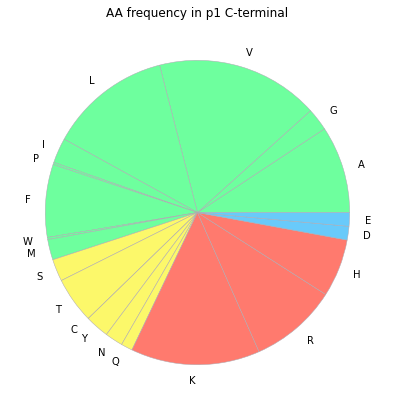

In [19]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
plt.xticks(range(len(Last_aa)), list(Last_aa.keys()))
plt.title('AA frequency in p1 C-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 C-terminal')

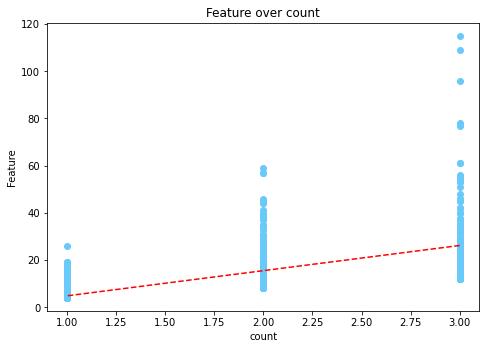

[10.675688   -5.88063833]
0.4772747946015098


In [20]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='#69cafa')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()
correlation_matrix = np.corrcoef(df['count'], df['#Feature'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [21]:
df.sort_values(['#Feature'], ascending=False)[0:30]

,Peptide,Mass,Length,RT,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.144000,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.942900,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.853000,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.640000,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.581800,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,NALAHKYH,952.815900,8.0,38.823333,61,19.0,4.0,38.0,3,NALA,HKYH,N,H
sp|P69905|HBA_HUMAN,AHVDDMPNALSAL,1360.964900,13.0,95.236667,61,26.0,13.0,22.0,3,AHVD,LSAL,A,L
sp|P68871|HBB_HUMAN,GDLSTPDAVMGNPKVKAHGK,2029.525825,20.0,51.032500,59,37.0,0.0,22.0,2,GDLS,AHGK,G,K
sp|P69905|HBA_HUMAN,VLSPADKTNVKAAWGKVGAHAGEYGAEALERM,3334.177100,32.0,99.773750,57,26.0,0.0,31.0,2,VLSP,LERM,V,M


In [22]:
#Here we sort on the C and N-cut

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_C[0:30]


,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
C-cut,,,,,
HKYH,763,230.0,52.0,481.0,39
LSAL,439,171.0,32.0,236.0,39
RLLV,252,78.0,40.0,134.0,39
ALER,281,129.0,48.0,103.0,38
GTFA,360,150.0,20.0,189.0,37
LERM,553,237.0,17.0,299.0,36
SKYR,391,105.0,40.0,246.0,35
PTTK,364,136.0,22.0,206.0,31
RMFL,275,129.0,4.0,142.0,28


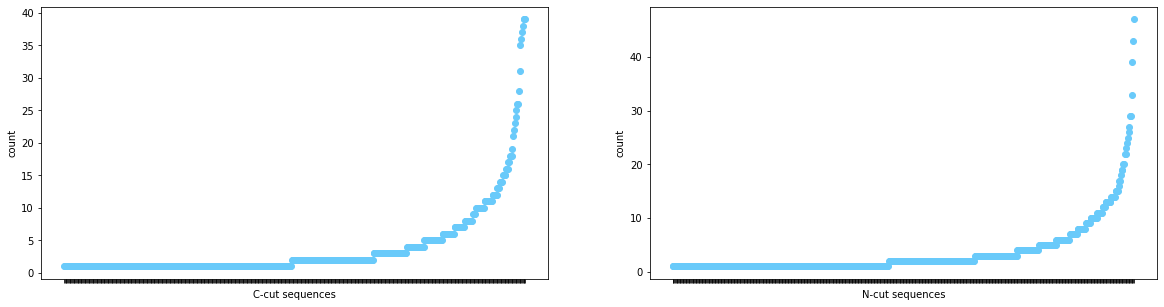

In [23]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

#df_N.reset_index(['Accession'], inplace=True)
#df_C.reset_index(['Accession'], inplace=True)
df_N=df.groupby(['N-cut']).sum()
df_C=df.groupby(['C-cut']).sum()
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
df_N=df_N.sort_values('count')
df_C=df_C.sort_values('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0


In [24]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()

df_C=df_C.sort_values(['count','#Feature'], ascending=False)
df_C.head()

,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
C-grouped,,,,,
NPNN,1334,570.0,83.0,680.0,162
NNNB,593,236.0,63.0,294.0,108
BNNN,676,294.0,44.0,337.0,96
NNBN,515,229.0,29.0,257.0,89
NBNB,606,286.0,41.0,279.0,75


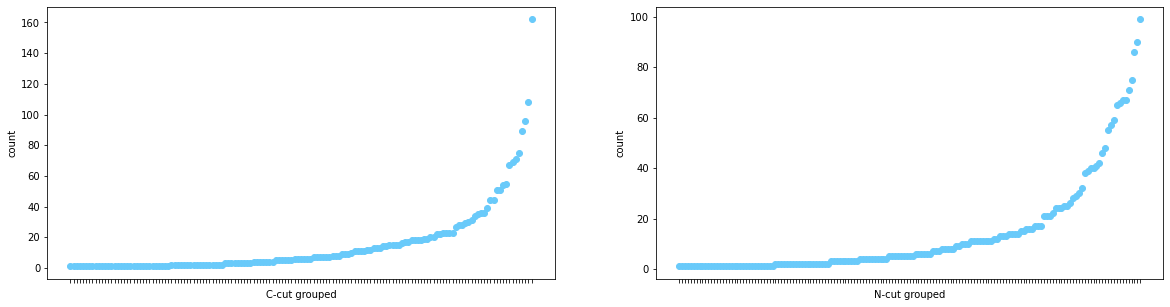

In [25]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['count'], ascending=True)
df_C=df_C.sort_values(['count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0

# Non-infected samples start here

In [26]:
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    for_stdev.append(len(data.index))
    print("Number of modified peptides in "+file+" "+str(len(data.index)))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature Sample 13','#Feature Sample 21', '#Feature Sample 33','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)

print("Standard deviation: "+str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])

df.head()

Number of modified peptides in peptide_sample_13.xlsx 3146
Number of un-modified peptides in peptide_sample_13.xlsx 2638
Number of modified peptides in peptide_sample_21.xlsx 4863
Number of un-modified peptides in peptide_sample_21.xlsx 4076
Number of modified peptides in peptide_sample_33.xlsx 4277
Number of un-modified peptides in peptide_sample_33.xlsx 3476
Standard deviation: 712.6356401103972
Total amount of peptides 10190
Average length: 12.375892857142857
Average mass: 1352.1624395512686
Total number of peptides with feature>=4: 1120
Number of peptides with feature>=4: 1120, in percent: 10.991167811579981 %


,Peptide,Mass,Length,RT,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH,A,H


In [27]:
 df.loc[(df.index == 'sp|P02671|FIBA_HUMAN')][0:30]

,Peptide,Mass,Length,RT,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT,M,T
sp|P02671|FIBA_HUMAN,ELERPGGNEITR,1370.186950,12.0,46.773333,29,7.0,13.0,9.0,3,ELER,EITR,E,R
sp|P02671|FIBA_HUMAN,LERPGGNEITR,1241.144350,11.0,51.153333,27,7.0,10.0,10.0,3,LERP,EITR,L,R
sp|P02671|FIBA_HUMAN,DSGEGDFLAEGGGVR,1464.648100,15.0,78.923333,26,12.0,7.0,7.0,3,DSGE,GGVR,D,R
sp|P02671|FIBA_HUMAN,ERPGGNEITR,1128.060400,10.0,32.956667,26,10.0,8.0,8.0,3,ERPG,EITR,E,R
sp|P02671|FIBA_HUMAN,MELERPGGNEI,1252.746053,11.0,64.008611,26,8.0,6.0,12.0,3,MELE,GNEI,M,I
sp|P02671|FIBA_HUMAN,MADEAGSEADHEGTHSTKR,2035.857700,19.0,21.230000,25,8.0,9.0,8.0,3,MADE,STKR,M,R
sp|P02671|FIBA_HUMAN,ADSGEGDFLAEGGGVR,1535.685200,16.0,74.143333,23,9.0,7.0,7.0,3,ADSG,GGVR,A,R


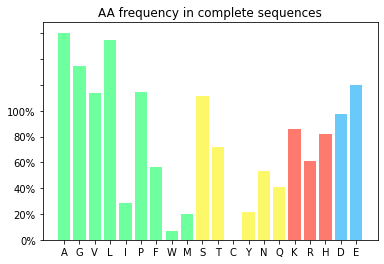

Text(0.5, 1.0, 'AA frequency in complete sequences')

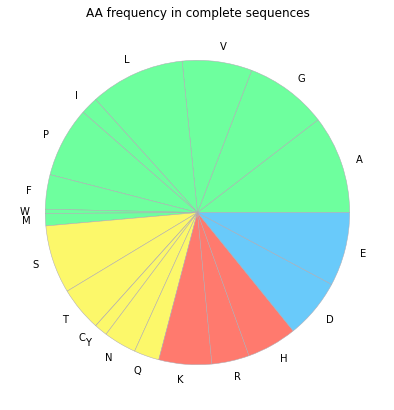

In [28]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in complete sequences')
plt.show()
fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in complete sequences')

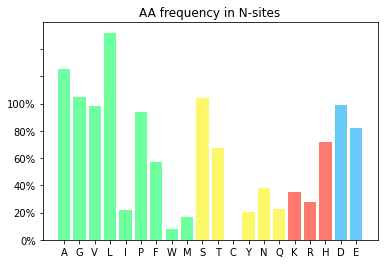

Text(0.5, 1.0, 'AA frequency in N-sites')

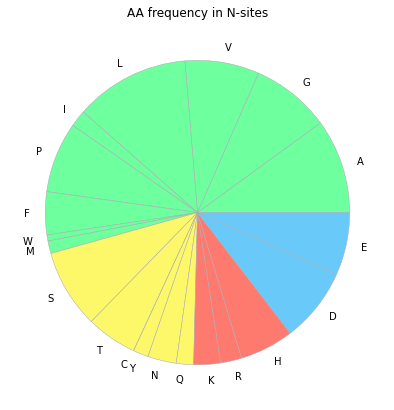

In [29]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(N_aminoacids.values(),labels = N_aminoacids.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in N-sites')

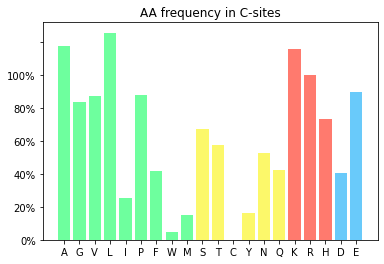

Text(0.5, 1.0, 'AA frequency in C-sites')

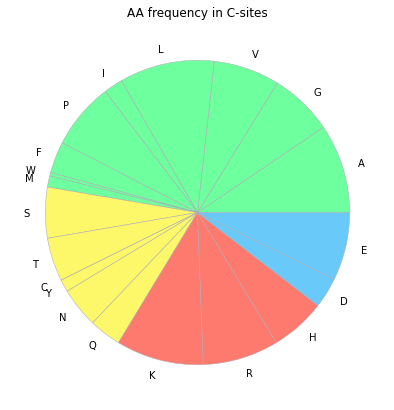

In [30]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp)
plt.title('AA frequency in C-sites')

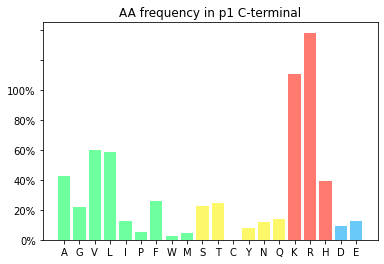

Text(0.5, 1.0, 'AA frequency in p1 C-terminal')

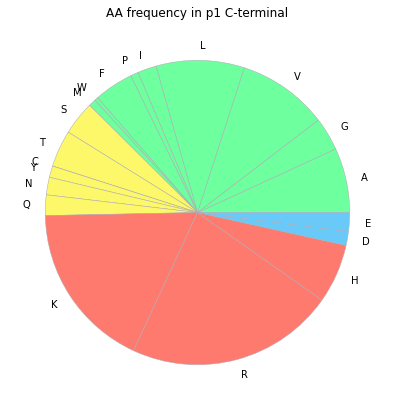

In [31]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
plt.xticks(range(len(Last_aa)), list(Last_aa.keys()))
plt.title('AA frequency in p1 C-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 C-terminal')

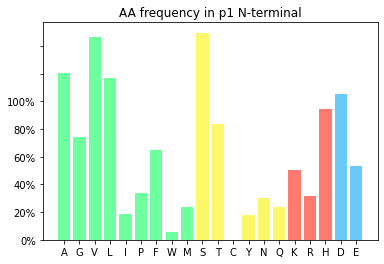

Text(0.5, 1.0, 'AA frequency in p1 N-terminal')

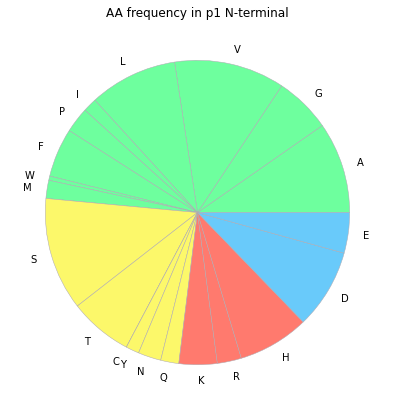

In [32]:
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
plt.xticks(range(len(First_aa)), list(First_aa.keys()))
plt.title('AA frequency in p1 N-terminal')
plt.show()

fig = plt.figure(figsize =(10, 7))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
plt.title('AA frequency in p1 N-terminal')

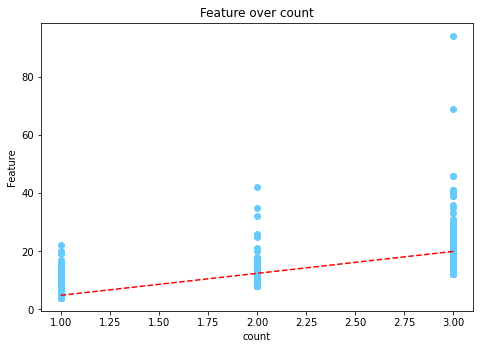

[ 7.55047414 -2.73092742]
0.5617755019462931


In [33]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='#69cafa')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()
correlation_matrix = np.corrcoef(df['count'], df['#Feature'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [34]:
df.sort_values(['#Feature'], ascending=False)[0:30]

,Peptide,Mass,Length,RT,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH,G,H
sp|P69905|HBA_HUMAN,AHVDDMPNALSALSDLHAH,2021.426875,19.0,95.971250,42,23.0,19.0,0.0,2,AHVD,LHAH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH,A,H
sp|P69905|HBA_HUMAN,VGAHAGEYGAEALER,1528.726900,15.0,58.986667,41,16.0,14.0,11.0,3,VGAH,ALER,V,R
sp|P69905|HBA_HUMAN,LTNAVAHVDDMPNALSALSDLHAH,2521.340603,24.0,111.584167,40,19.0,16.0,5.0,3,LTNA,LHAH,L,H
sp|P69905|HBA_HUMAN,MFLSFPTTK,1078.544500,9.0,98.605000,40,12.0,14.0,14.0,3,MFLS,PTTK,M,K


In [35]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_N.head()


#Feature  #Feature Sample 13  #Feature Sample 21  \
Accession           N-cut                                                     
sp|P69905|HBA_HUMAN VLSP        134                35.0                48.0   
                    TYFP        124                19.0                48.0   
                    VGAH        130                43.0                42.0   
sp|P68871|HBB_HUMAN VHLT        123                31.0                47.0   
sp|P69905|HBA_HUMAN LTNA        145                55.0                47.0   

                           #Feature Sample 33  count  
Accession           N-cut                             
sp|P69905|HBA_HUMAN VLSP                 51.0     22  
                    TYFP                 57.0     21  
                    VGAH                 45.0     20  
sp|P68871|HBB_HUMAN VHLT                 45.0     19  
sp|P69905|HBA_HUMAN LTNA                 43.0     16

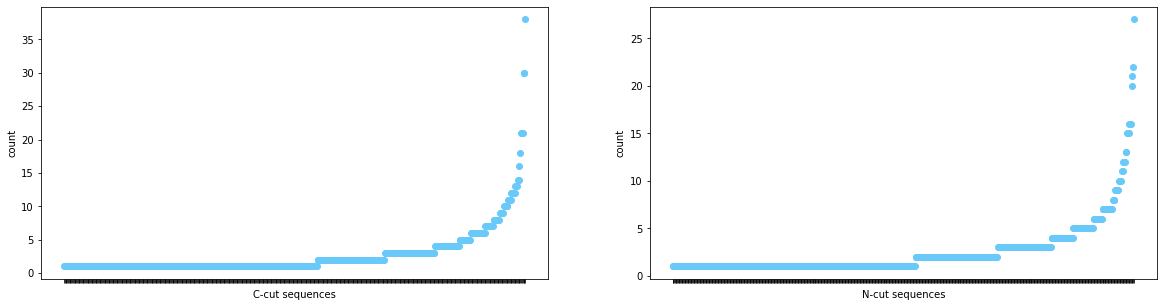

In [36]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('count')
df_C=df_C.sort_values('count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0

In [37]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['#Feature'], ascending=False)
df_C.head()

,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count
C-grouped,,,,,
NBNB,604,207.0,273.0,122.0,76
NNNB,512,132.0,165.0,215.0,106
NNPN,449,102.0,138.0,209.0,66
NNAB,303,84.0,94.0,125.0,53
NPNB,288,70.0,118.0,100.0,53


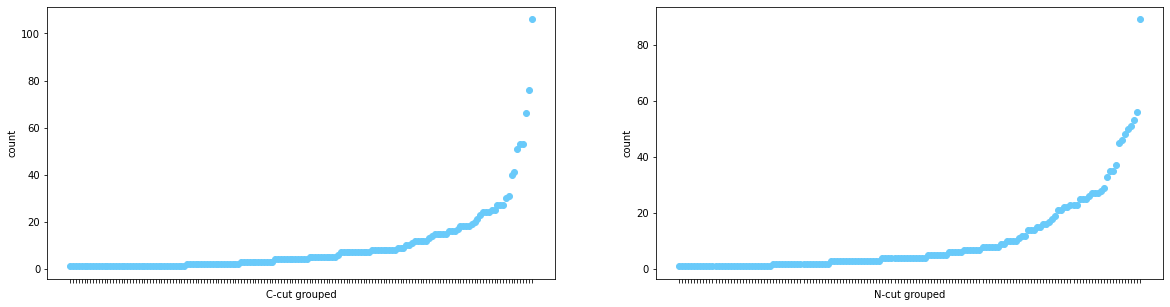

In [38]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['count'], ascending=True)
df_C=df_C.sort_values(['count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count'], color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['count'], color='#69cafa') #row=1, col=0